# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

# Create "Dataset" class

In [2]:
class Dataset():
    def __init__(self, csv_file, train, test_size, transform = None, labels=True):
        data = pd.read_csv(csv_file)
        key = int((1-test_size)*len(data))
        if train:
            self.data = pd.DataFrame(data.iloc[:key,:])
        else:
            self.data = pd.DataFrame(data.iloc[key:,:])
        self.transform = transform
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.labels:
            out = self.data.iloc[idx,1:].to_numpy().reshape((28,28)).astype("double")
            labels = self.get_label(idx)
        else:
            out = self.data.iloc[idx,:].to_numpy().reshape((28,28)).astype("double")
            labels = []
        out = out/255.
        if self.transform:
            out = self.transform(out)
        return out, labels

    def get_label(self,idx):
        return self.data.iloc[idx,0].item()

# Load data and transformations

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

train_dataset = Dataset("Data/train.csv", train = True, test_size = 0.2, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 100, shuffle = True)
test_dataset = Dataset("Data/train.csv", train = False, test_size = 0.2, transform = transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = False)
train_iter = iter(train_loader)
test_iter = iter(test_loader)

# Prepare NN model

In [4]:
class Classifier(nn.Module):
    def __init__(self, x_in, x1, x2, x_out):
        super().__init__()
        self.linear1 = nn.Linear(x_in, x1)
        self.linear2 = nn.Linear(x1,x2)
        self.linear3 = nn.Linear(x2,x_out)
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x        

# Training settings

In [5]:
model = Classifier(28*28, 135, 65, 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Training

In [6]:
epochs = 15
epoch_loss = []
epoch_acc = []
epoch_test_loss = []
epoch_test_acc = []
for e in range(epochs):
    actual_loss = 0.0
    actual_preds = 0.0
    test_loss = 0.0
    test_preds = 0.0
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1).float()
        out = model(images)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        actual_loss += loss.item()
        _, preds = torch.max(out,1)
        actual_preds += torch.sum(preds == labels)
    else:
        loss = actual_loss/len(train_loader)
        acc = actual_preds/len(train_loader)
        epoch_loss.append(loss)
        epoch_acc.append(acc)
        print('epoch {}'.format(e+1))
        print('Loss {}'.format(loss))
        print('Acc {}'.format(acc))
        
        for images, labels in test_loader:
            images = images.view(images.shape[0], -1).float()
            out = model(images)
            loss = criterion(out, labels)
            test_loss += loss.item()
            _, preds = torch.max(out,1)
            test_preds += torch.sum(preds == labels)
        else:
            test_loss = test_loss/len(test_loader)
            test_acc = test_preds/len(test_loader)
            epoch_test_loss.append(test_loss)
            epoch_test_acc.append(test_acc)
            print('Test_loss {}'.format(test_loss))
            print('Test_acc {}'.format(test_acc))

epoch 1
Loss 1.249494396770994
Acc 68.10118865966797
Test_loss 0.6037014864739918
Test_acc 85.01190185546875
epoch 2
Loss 0.48589993960091044
Acc 87.23213958740234
Test_loss 0.4109301057954629
Test_acc 89.1547622680664
epoch 3
Loss 0.38177093610699686
Acc 89.16666412353516
Test_loss 0.3501886106317952
Test_acc 90.29762268066406
epoch 4
Loss 0.3411232293361709
Acc 90.07737731933594
Test_loss 0.32382850295730997
Test_acc 90.80952453613281
epoch 5
Loss 0.31577580528599875
Acc 90.96428680419922
Test_loss 0.3072465042627993
Test_acc 91.28571319580078
epoch 6
Loss 0.2978457977019605
Acc 91.36607360839844
Test_loss 0.2961938979015464
Test_acc 91.78571319580078
epoch 7
Loss 0.28430390825849916
Acc 91.79166412353516
Test_loss 0.27824934297019527
Test_acc 92.07142639160156
epoch 8
Loss 0.27110480940679
Acc 92.18452453613281
Test_loss 0.28135704603933154
Test_acc 91.88095092773438
epoch 9
Loss 0.2594278741716629
Acc 92.49404907226562
Test_loss 0.2599735374429396
Test_acc 92.57142639160156
epoch 1

# Plot loss

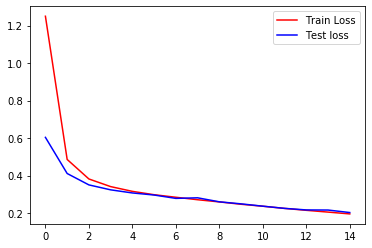

In [7]:
plt.plot(epoch_loss, color ='r', label = "Train Loss")
plt.plot(epoch_test_loss, color ='b', label = "Test loss")
plt.legend()
plt.show()

# Plot accuracy

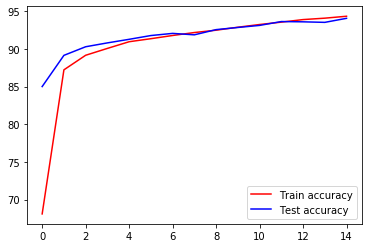

In [8]:
plt.plot(epoch_acc, color ='r', label = "Train accuracy")
plt.plot(epoch_test_acc, color ='b', label = "Test accuracy")
plt.legend()
plt.show()

# GPU settings

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Prepare DL model

In [10]:
class DL_classifier(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 20, 5, 1)
      self.conv2 = nn.Conv2d(20, 50, 5, 1)
      self.fc1 = nn.Linear(4*4*50, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*50)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

# Training settings

In [11]:
model_dl = DL_classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dl.parameters(), lr = 0.0001)

# Training

In [12]:
epochs = 15
epoch_loss = []
epoch_acc = []
epoch_test_loss = []
epoch_test_acc = []
for e in range(epochs):
    actual_loss = 0.0
    actual_preds = 0.0
    test_loss = 0.0
    test_preds = 0.0
    for images, labels in train_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        out = model_dl(images)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        actual_loss += loss.item()
        _, preds = torch.max(out,1)
        actual_preds += torch.sum(preds == labels)
    else:
        loss = actual_loss/len(train_loader)
        acc = actual_preds/len(train_loader)
        epoch_loss.append(loss)
        epoch_acc.append(acc)
        print('epoch {}'.format(e+1))
        print('Loss {}'.format(loss))
        print('Acc {}'.format(acc))
        
        for images, labels in test_loader:
            images = images.float().to(device)
            labels = labels.to(device)
            out = model_dl(images)
            loss = criterion(out, labels)
            test_loss += loss.item()
            _, preds = torch.max(out,1)
            test_preds += torch.sum(preds == labels)
        else:
            test_loss = test_loss/len(test_loader)
            test_acc = test_preds/len(test_loader)
            epoch_test_loss.append(test_loss)
            epoch_test_acc.append(test_acc)
            print('Test_loss {}'.format(test_loss))
            print('Test_acc {}'.format(test_acc))

epoch 1
Loss 0.8528392098489261
Acc 77.64583587646484
Test_loss 0.30352177612838294
Test_acc 91.28571319580078
epoch 2
Loss 0.23889592285489752
Acc 92.89881134033203
Test_loss 0.1782355129363991
Test_acc 94.80952453613281
epoch 3
Loss 0.15702292361363238
Acc 95.36904907226562
Test_loss 0.13002282611670948
Test_acc 96.22618865966797
epoch 4
Loss 0.1194897881442947
Acc 96.39286041259766
Test_loss 0.1047007113783842
Test_acc 96.72618865966797
epoch 5
Loss 0.09642426061466158
Acc 97.1339340209961
Test_loss 0.08652313486007708
Test_acc 97.3452377319336
epoch 6
Loss 0.08275154146498867
Acc 97.54167175292969
Test_loss 0.08014103446510576
Test_acc 97.58333587646484
epoch 7
Loss 0.07225231760891065
Acc 97.79464721679688
Test_loss 0.07292744898725123
Test_acc 97.60714721679688
epoch 8
Loss 0.06345609788660936
Acc 98.0714340209961
Test_loss 0.06366094257239074
Test_acc 97.95238494873047
epoch 9
Loss 0.05815709279184895
Acc 98.18452453613281
Test_loss 0.05882238547339858
Test_acc 98.22618865966797

# Plot loss

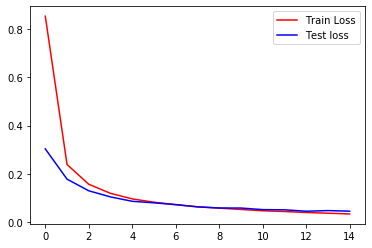

In [13]:
plt.plot(epoch_loss, color ='r', label = "Train Loss")
plt.plot(epoch_test_loss, color ='b', label = "Test loss")
plt.legend()
plt.show()

# Plot accuracy

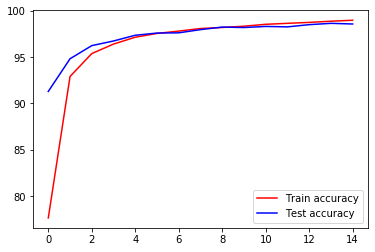

In [14]:
plt.plot(epoch_acc, color ='r', label = "Train accuracy")
plt.plot(epoch_test_acc, color ='b', label = "Test accuracy")
plt.legend()
plt.show()

# Function for converting image to normal version

In [15]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

# Plot sample predictions NN

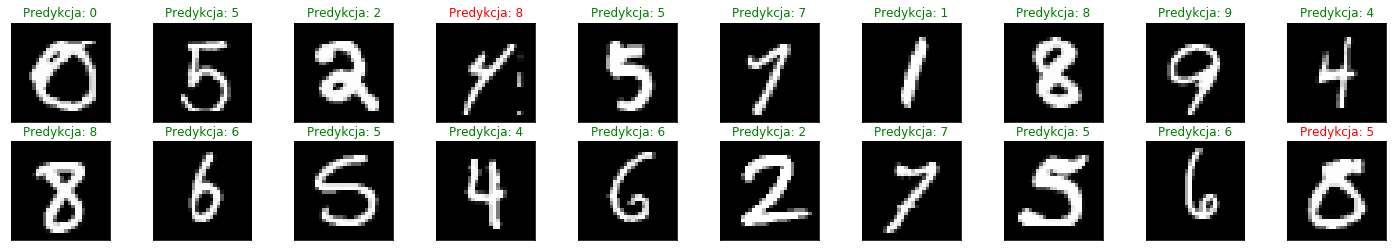

In [16]:
images, labels = train_iter.next()
images_flat = images.view(images.shape[0], -1).float()
out = model(images_flat)
_, preds = torch.max(out,1)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    title = 'Predykcja: {}'.format(preds[idx]) 
    ax.set_title(title, color= ('g' if preds[idx]==labels[idx].item() else'r'))

# Plot sample predictions DL

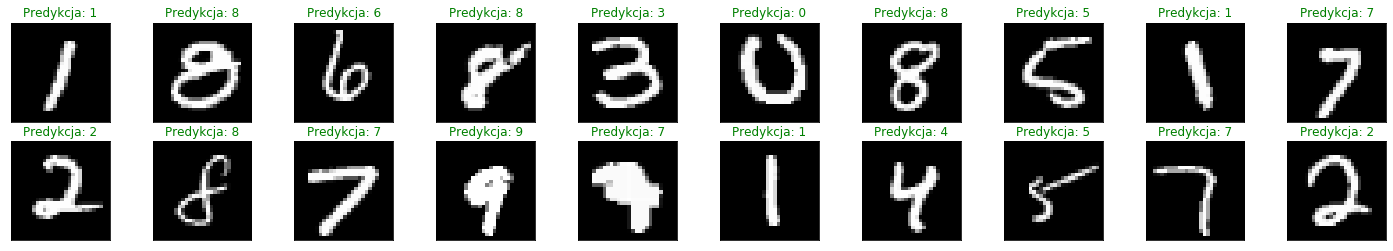

In [17]:
images, labels = train_iter.next()
images_flat = images.float().to(device)
out = model_dl(images_flat)
_, preds = torch.max(out,1)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    title = 'Predykcja: {}'.format(preds[idx]) 
    ax.set_title(title, color= ('g' if preds[idx]==labels[idx].item() else'r'))

# Load images for prediction

In [19]:
new_dataset = Dataset("Data/test.csv", train = True, test_size = 0, transform = transform, labels = False)
new_loader = torch.utils.data.DataLoader(new_dataset, batch_size = 100, shuffle = False)
preds = []
for images,_ in new_loader:
    images = images.float().to(device)
    out = model_dl(images)
    _, pred = torch.max(out, 1)
    preds = np.concatenate((preds,pred.to('cpu').numpy()))

# Save predictions to file

In [20]:
preds = preds.astype(int)
y = np.zeros((28000, 2), dtype = int)
y[:,0] = range(1,28001)
y[:,1] = preds
df = pd.DataFrame(y,columns= ["ImageId","Label"])
df.to_csv("output_nn.csv", index = False)